# 2. Data Analysis & Preprocessing

This JupyterNotebook is part of an exercise series titled *Data Analysis & Preprocessing*. The series itself includes practical exercises for lectures *3. Getting to Know Your Data* and *4. Data Preprocessing*. 

Exercises for data analysis and preprocessing is divided into three parts in total, namely:

- Part One: Getting to Know Your Data
- Part Two: Preprocessing - Data Cleaning & Data Integration
- Part Three: Preprocessing - Data Reduction, Data Transformation & Data Discretization

Recall that we have two exercise groups. Depending on how each group progresses, some parts of these exercises may not be discussed in its entirety. If questions arise, ask them in your study group or in our StudOn forum.

## Part Three: Preprocessing - Data Reduction, Data Transformation & Data Discretization

In this part you will apply the theoretical knowledge gained in the second part of the lecture *4. Data Preprocessing*.

In [1]:
# Import the required libraries
import tempfile
import sqlite3
import os
import urllib.request
import sklearn.decomposition
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Create a temporary directory
dataset_folder = tempfile.mkdtemp()

# Build path to database
database_path = os.path.join(dataset_folder, "adventure-works.db")

# Get the database
urllib.request.urlretrieve(
    "https://github.com/FAU-CS6/KDD-Databases/raw/main/AdventureWorks/adventure-works.db",
    database_path,
)

# Open connection to the adventure-works.db
connection = sqlite3.connect(database_path)

In [3]:
# Create the clean DataFrame(s)
# Order DataFrame
order_df = pd.read_sql_query(
    "SELECT p.ProductID,p.Name,p.ProductNumber,p.MakeFlag,p.FinishedGoodsFlag,p.Color,p.SafetyStockLevel,"
    "p.ReorderPoint,p.StandardCost,p.ListPrice,p.Size,p.SizeUnitMeasureCode,p.WeightUnitMeasureCode,p.Weight,"
    "p.DaysToManufacture,p.ProductLine,p.Class,p.Style,p.ProductSubcategoryID,p.ProductModelID,p.SellStartDate,"
    "p.SellEndDate,p.DiscontinuedDate,d.PurchaseOrderID,d.PurchaseOrderDetailID,d.DueDate,d.OrderQty,d.ProductID,"
    "d.UnitPrice,d.ReceivedQty,d.RejectedQty,h.RevisionNumber,h.Status,h.EmployeeID,h.VendorID,h.ShipMethodID,"
    "h.OrderDate,h.ShipDate,h.SubTotal,h.TaxAmt,h.Freight,h.TotalDue,e.NationalIDNumber,e.LoginID,e.OrganizationNode,"
    "e.JobTitle,e.BirthDate,e.MaritalStatus,e.Gender,e.HireDate,e.SalariedFlag,e.VacationHours,e.SickLeaveHours,"
    "e.CurrentFlag,r.PersonType,r.NameStyle,r.Title,r.FirstName,r.MiddleName,r.LastName,r.Suffix,r.EmailPromotion,"
    "r.AdditionalContactInfo,r.Demographics "
    "FROM Product p "
    "JOIN PurchaseOrderDetail d ON p.ProductID = d.ProductID "
    "JOIN PurchaseOrderHeader h ON d.PurchaseOrderID = h.PurchaseOrderID "
    "JOIN Employee e ON h.EmployeeID = e.BusinessEntityID "
    "JOIN Person r ON e.BusinessEntityID = r.BusinessEntityID",
    connection,
    index_col="PurchaseOrderDetailID",
)

# CurrencyRate DataFrame
currency_rate_df = pd.read_sql_query(
    "SELECT STRFTIME('%Y-%m-%d', CurrencyRateDate) AS CurrencyRateDate,AverageRate,EndOfDayRate "
    "FROM CurrencyRate "
    "WHERE FromCurrencyCode='USD' AND ToCurrencyCode='EUR'",
    connection,
    index_col="CurrencyRateDate",
)

### Normalization

One method introduced in the lecture and frequently used in Data Science is normalization. In order to apply this practically, we will first take a look at a part of the `order_df` already known from Part One. More precisely, we are looking at some numeric attributes from `order_df`.

<div class="alert alert-block alert-info">

**Task:** Display the head of the attributes `SubTotal`, `Freight` and `OrderQty` from `order_df`.
</div>

In [4]:
# Display the head of SubTotal, Freight and OrderQty

In [5]:
# Display the head of SubTotal, Freight and OrderQty
order_df[["SubTotal", "Freight", "OrderQty"]].head(20)

,SubTotal,Freight,OrderQty
PurchaseOrderDetailID,,,
1,201.0400,5.0260,4
2,272.1015,6.8025,3
3,272.1015,6.8025,3
4,8847.3000,221.1825,550
5,171.0765,4.2769,3
6,20397.3000,509.9325,550
7,14628.0750,365.7019,550
8,58685.5500,1467.1388,550
9,58685.5500,1467.1388,550


<div class="alert alert-block alert-info">

**Task:** Display the minimum, maximum, mean, and standard deviation of `SubTotal`, `Freight` and `OrderQty`.
</div>

In [6]:
# Display the minimum, maximum, mean, and standard deviation of SubTotal, Freight and OrderQty

In [7]:
# Display the minimum, maximum, mean, and standard deviation of SubTotal, Freight and OrderQty
order_df[["SubTotal", "Freight", "OrderQty"]].agg(["min", "max", "mean", "std"])

,SubTotal,Freight,OrderQty
min,37.075500,0.926900,3.000000
max,997680.000000,19953.600000,8000.000000
mean,18500.585391,453.636236,265.532730
std,39344.367563,862.103697,355.926589


As can be seen, the three attributes differ significantly with respect to their distribution of values posing a hindrance for some knowledge discovery tasks. To alleviate this problem, normalization is employed to scale attribute values to a smaller range.

In the lecture you were introduced to three different variants of normalization: min-max normalization, z-score normalization, and normalization by decimal scaling.

Below you can see the implementation of one of the normalization methods for the attributes `SubTotal`, `Freight` and `OrderQty`:

In [8]:
# It is always good to define methods that you may want to use more often as a function.
def mystery_normalization(df):
    # Create a copy to avoid overriding original content
    normalized = df.copy()

    # Normalize each column individually
    for column in normalized.columns:
        normalized[column] = (
            normalized[column] - normalized[column].mean()
        ) / normalized[column].std()

    return normalized


# Apply previously defined function
mystery_normalization_df = mystery_normalization(
    order_df[["SubTotal", "Freight", "OrderQty"]]
)
mystery_normalization_df.head(20)

,SubTotal,Freight,OrderQty
PurchaseOrderDetailID,,,
1,-0.465112,-0.520367,-0.734794
2,-0.463306,-0.518306,-0.737604
3,-0.463306,-0.518306,-0.737604
4,-0.245354,-0.269635,0.799230
5,-0.465874,-0.521236,-0.737604
6,0.048208,0.065301,0.799230
7,-0.098426,-0.102000,0.799230
8,1.021365,1.175616,0.799230
9,1.021365,1.175616,0.799230


<div class="alert alert-block alert-info">

**Task:** Determine whether the above function `mystery_normalization` is an implementation of min-max normalization, z-score normalization, or normalization by decimal scaling.
</div>

<b>The function is an implementation of:</b>
1. [ ] Min-max normalization (for the interval [0, 1])
2. [ ] Z-score normalization
3. [ ] Normalization by decimal scaling

<b>The function is an implementation of:</b>
1. [ ] Min-max normalization (for the interval [0, 1])
2. [X] Z-score normalization
3. [ ] Normalization by decimal scaling

<div class="alert alert-block alert-info">

**Task:** Implement a function for each of the three normalization methods you got to know. (You may, of course, reuse the above code when you work on the corresponding function).
</div>

In [9]:
# Implement min-max normalization for the interval [0, 1]
def min_max_normalization(df):
    # Create a copy to avoid overriding original content
    normalized = df.copy()

    # ...

    return normalized


# Apply min-max normalization
min_max_df = min_max_normalization(order_df[["SubTotal", "Freight", "OrderQty"]])
min_max_df.head(20)

,SubTotal,Freight,OrderQty
PurchaseOrderDetailID,,,
1,201.0400,5.0260,4
2,272.1015,6.8025,3
3,272.1015,6.8025,3
4,8847.3000,221.1825,550
5,171.0765,4.2769,3
6,20397.3000,509.9325,550
7,14628.0750,365.7019,550
8,58685.5500,1467.1388,550
9,58685.5500,1467.1388,550


In [10]:
# Implement min-max normalization for the interval [0, 1]
def min_max_normalization(df):
    # Create a copy to avoid overriding original content
    normalized = df.copy()

    # Normalize each column individually
    for column in normalized.columns:
        normalized[column] = (df[column] - df[column].min()) / (
            df[column].max() - df[column].min()
        )

    return normalized


# Apply min-max normalization
min_max_df = min_max_normalization(order_df[["SubTotal", "Freight", "OrderQty"]])
min_max_df.head(20)

,SubTotal,Freight,OrderQty
PurchaseOrderDetailID,,,
1,0.000164,0.000205,0.000125
2,0.000236,0.000294,0.000000
3,0.000236,0.000294,0.000000
4,0.008831,0.011039,0.068401
5,0.000134,0.000168,0.000000
6,0.020408,0.025511,0.068401
7,0.014625,0.018282,0.068401
8,0.058787,0.073484,0.068401
9,0.058787,0.073484,0.068401


In [11]:
# Display the minimum, maximum, mean, and standard deviation values of min_max_df
min_max_df.agg([min, max, "mean", "std"])

,SubTotal,Freight,OrderQty
min,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000
mean,0.018507,0.022689,0.032829
std,0.039437,0.043207,0.044508


In [12]:
# Implement z-score normalization
def z_score_normalization(df):
    # Create a copy to avoid overriding original content
    normalized = df.copy()

    # ...

    return normalized


# Apply z-score normalization
z_score_df = z_score_normalization(order_df[["SubTotal", "Freight", "OrderQty"]])
z_score_df.head(20)

,SubTotal,Freight,OrderQty
PurchaseOrderDetailID,,,
1,201.0400,5.0260,4
2,272.1015,6.8025,3
3,272.1015,6.8025,3
4,8847.3000,221.1825,550
5,171.0765,4.2769,3
6,20397.3000,509.9325,550
7,14628.0750,365.7019,550
8,58685.5500,1467.1388,550
9,58685.5500,1467.1388,550


In [13]:
# Implement z-score normalization
def z_score_normalization(df):
    # Create a copy to avoid overriding original content
    normalized = df.copy()

    # Normalize each column individually
    for column in normalized.columns:
        normalized[column] = (
            normalized[column] - normalized[column].mean()
        ) / normalized[column].std()

    return normalized


# Apply z-score normalization
z_score_df = z_score_normalization(order_df[["SubTotal", "Freight", "OrderQty"]])
z_score_df.head(20)

,SubTotal,Freight,OrderQty
PurchaseOrderDetailID,,,
1,-0.465112,-0.520367,-0.734794
2,-0.463306,-0.518306,-0.737604
3,-0.463306,-0.518306,-0.737604
4,-0.245354,-0.269635,0.799230
5,-0.465874,-0.521236,-0.737604
6,0.048208,0.065301,0.799230
7,-0.098426,-0.102000,0.799230
8,1.021365,1.175616,0.799230
9,1.021365,1.175616,0.799230


In [14]:
# Display the minimum, maximum, mean and standard deviation values of z_score_df
z_score_df.agg([min, max, "mean", "std"])

,SubTotal,Freight,OrderQty
min,-4.692796e-01,-5.251217e-01,-7.376036e-01
max,2.488741e+01,2.261905e+01,2.173051e+01
mean,-3.855970e-17,3.213308e-17,-3.213308e-18
std,1.000000e+00,1.000000e+00,1.000000e+00


In [15]:
# Implement normalization by decimal scaling
def normalization_by_decimal_scaling(df):
    # Create a copy to avoid overriding original content
    normalized = df.copy()

    # ...

    return normalized


# Apply normalization_by_decimal_scaling
decimal_scaling_df = normalization_by_decimal_scaling(
    order_df[["SubTotal", "Freight", "OrderQty"]]
)
decimal_scaling_df.head(20)

,SubTotal,Freight,OrderQty
PurchaseOrderDetailID,,,
1,201.0400,5.0260,4
2,272.1015,6.8025,3
3,272.1015,6.8025,3
4,8847.3000,221.1825,550
5,171.0765,4.2769,3
6,20397.3000,509.9325,550
7,14628.0750,365.7019,550
8,58685.5500,1467.1388,550
9,58685.5500,1467.1388,550


In [16]:
# Implement normalization by decimal scaling
def normalization_by_decimal_scaling(df):
    # Create a copy to avoid overriding original content
    normalized = df.copy()

    # Normalize each column individually
    for column in normalized.columns:
        # Find k
        k = 0
        while normalized[column].abs().max() / (10 ** k) >= 1:
            k += 1

        # Compute normalization of the column
        normalized[column] = normalized[column] / (10 ** k)

    return normalized


# Apply normalization_by_decimal_scaling
decimal_scaling_df = normalization_by_decimal_scaling(
    order_df[["SubTotal", "Freight", "OrderQty"]]
)
decimal_scaling_df.head(20)

,SubTotal,Freight,OrderQty
PurchaseOrderDetailID,,,
1,0.000201,0.000050,0.0004
2,0.000272,0.000068,0.0003
3,0.000272,0.000068,0.0003
4,0.008847,0.002212,0.0550
5,0.000171,0.000043,0.0003
6,0.020397,0.005099,0.0550
7,0.014628,0.003657,0.0550
8,0.058686,0.014671,0.0550
9,0.058686,0.014671,0.0550


In [17]:
# Display the minimum, maximum, mean and standard deviation values of decimal_scaling_df
decimal_scaling_df.agg([min, max, "mean", "std"])

,SubTotal,Freight,OrderQty
min,0.000037,0.000009,0.000300
max,0.997680,0.199536,0.800000
mean,0.018501,0.004536,0.026553
std,0.039344,0.008621,0.035593


Note that each normalization results in different scaled values. It is therefore important to consider which normalization method best serves your purpose. 

<div class="alert alert-block alert-info">

**Task:** Consider when the various normalization methods presented might be beneficial.
</div>

Write down your solution here:

- <b>Min-max normalization:</b>
Min-max normalization is advantageous when values must be secured in a fixed interval and this interval shall be used as good as possible. For example, in certain deep learning methods it is essential that values lie in the value range [0, 1] in order to avoid incorrect results.

- <b>Z-score normalization:</b><br />
The goal of z-score normalization (also called standardization) is not to bring all values into a fixed range of values. In this type of normalization, the attributes are aligned in a different way. Thus, the Z-Score normalization achieves that the mean of all attributes is as close as possible to 0 and the attribute values have a standard deviation of 1 to each other. 

- <b>Normalization by decimal scaling:</b><br />
Although normalization by decimal scaling assures the user that all output values are in the value range [-1, -1], it rarely actually uses this range (see example). The advantage compared to min-max normalization is that normalization is not done with arbitrary divisors, but with a power of ten. Since we humans are used to the decimal system, the connection between value and normalized value is easier to recognize. (Min-Max normalization: 19953.6 becomes 1.0 - Normalization by decimal scaling: 19953.6 becomes 0.199536)

### Discretization

Another commonly used method is discretization. This is used to convert a continuous values to discrete values. This method is best demonstrated on a continuous attribute which is why we take a look at the `currency_rate_df` which represents exchange rates from USD to EUR.

In [18]:
# Print the head of currency_rate_df
currency_rate_df.head(20)

,AverageRate,EndOfDayRate
CurrencyRateDate,,
2011-05-31,0.9697,0.9703
2011-06-01,0.9676,0.9670
2011-06-02,0.9610,0.9615
2011-06-03,0.9617,0.9617
2011-06-04,0.9704,0.9711
2011-06-05,0.9718,0.9715
2011-06-06,0.9708,0.9716
2011-06-07,0.9697,0.9690
2011-06-08,0.9697,0.9706


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(-200.0, 0, '2013-11-13'),
  Text(0.0, 0, '2011-05-31'),
  Text(200.0, 0, '2011-12-17'),
  Text(400.0, 0, '2012-07-04'),
  Text(600.0, 0, '2013-01-20'),
  Text(800.0, 0, '2013-08-08'),
  Text(1000.0, 0, '2014-02-24'),
  Text(1200.0, 0, '')])

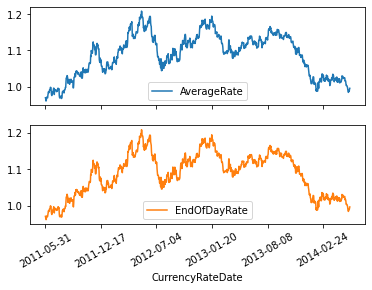

In [19]:
# Draw the progression of the two rates over time
currency_rate_df.plot(subplots=True)
plt.xticks(rotation=30)

Sometimes it is desirable to divide attribute values into *groups* resulting in fewer values that are easier to handle. Graphically, we have already applied a method in Part One that does just that: Histogram plot.

<div class="alert alert-block alert-info">

**Task:** Draw a histogram with five bins for the attributes `AverageRate` and `EndOfDayRate`.

</div>

In [20]:
# Draw a histogram for AverageRate and EndOfDayRate

array([[<AxesSubplot:title={'center':'AverageRate'}>,
        <AxesSubplot:title={'center':'EndOfDayRate'}>]], dtype=object)

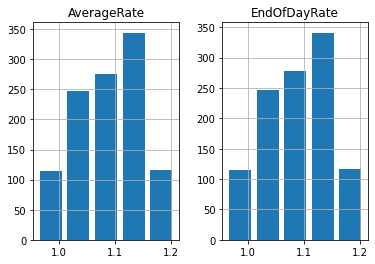

In [21]:
# Draw a histogram for AverageRate and EndOfDayRate
currency_rate_df.hist(bins=5, rwidth=0.8)

Although histogram analysis divides individual values into different groups and thus discretizes data, it completely ignores the temporal aspect. More specifically, both attributes `AverageRate` and `EndOfDayRate` constitute time series, i. e. data is indexed by time, and binning data values ignores this time dependency. 

Alternatively, data can be binned and thus discretize by maintaining the temporal nature by partitioning the data values to equal-width bins. This is possible in pandas via the fucntion `cut`.

<div class="alert alert-block alert-info">

**Task:** Use `cut()` to distribute the attribute values of `AverageRate` into five bins with equal width. (Help: [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.cut.html))
</div>

In [22]:
# Distribute the attribute values of AverageRate into bins with equal width

In [23]:
# Distribute the attribute values of AverageRate into bins with equal width
pd.cut(currency_rate_df["AverageRate"], bins=5)

CurrencyRateDate
2011-05-31    (0.961, 1.01]
2011-06-01    (0.961, 1.01]
2011-06-02    (0.961, 1.01]
2011-06-03    (0.961, 1.01]
2011-06-04    (0.961, 1.01]
                  ...      
2014-05-27    (0.961, 1.01]
2014-05-28    (0.961, 1.01]
2014-05-29    (0.961, 1.01]
2014-05-30    (0.961, 1.01]
2014-05-31    (0.961, 1.01]
Name: AverageRate, Length: 1097, dtype: category
Categories (5, interval[float64, right]): [(0.961, 1.01] < (1.01, 1.06] < (1.06, 1.109] < (1.109, 1.158] < (1.158, 1.208]]

<div class="alert alert-block alert-info">

**Task:** Find out how to interpret the interval notation used in the new attribute values and what boundaries each of the five bins has. 

</div>

Write down your solution here:

**Interval notation:** Interval notation can be read as "lower limit, upper limit", where the brackets indicate whether a value is included ("[" or "]") or excluded ("(" or )") in the limit.

**Boundaries:**

- **Bin 1:** From 0.961 (excl.) to 1.01 (inkl.)
- **Bin 2:** From 1.01 (excl.) to 1.06 (inkl.)
- **Bin 3:** From 1.06 (excl.) to 1.109 (inkl.)
- **Bin 4:** From 1.109 (excl.) to 1.158 (inkl.)
- **Bin 5:** From 1.158 (excl.) to 1.208 (inkl.)

Besides equal-width partioning, pandas also supports equal-depth partioning where each bin contains approximately the same *number of values*. This is done with the function `qcut`.

<div class="alert alert-block alert-info">

**Task:** Use `qcut()` to arrange attribute values of AverageRate into five bins with equal depth. (Help: <a href="https://pandas.pydata.org/docs/reference/api/pandas.qcut.html">pandas documentation</a>)
</div>

In [24]:
# Distribute attribute values of AverageRate into bins with equal depth

In [25]:
# Distribute attribute values of AverageRate into bins with equal depth
pd.qcut(currency_rate_df["AverageRate"], q=5)

# Note: Parameter q specifies the number of quantiles, not the number of bins.

CurrencyRateDate
2011-05-31    (0.96, 1.025]
2011-06-01    (0.96, 1.025]
2011-06-02    (0.96, 1.025]
2011-06-03    (0.96, 1.025]
2011-06-04    (0.96, 1.025]
                  ...      
2014-05-27    (0.96, 1.025]
2014-05-28    (0.96, 1.025]
2014-05-29    (0.96, 1.025]
2014-05-30    (0.96, 1.025]
2014-05-31    (0.96, 1.025]
Name: AverageRate, Length: 1097, dtype: category
Categories (5, interval[float64, right]): [(0.96, 1.025] < (1.025, 1.076] < (1.076, 1.113] < (1.113, 1.139] < (1.139, 1.208]]

The disadvantage of this "pure" partitioning is that the attribute values are no longer purely numerical attributes and thus further processing is only possible to a limited extent. Therefore, one or two representative values are often selected for each bin, to which all values within the bin are smoothed.

In the lecture the variant smoothing by bin means was presented, which we will now have a look at here. 

<div class="alert alert-block alert-info">

**Task:** Implement a method for smoothing by bin means with equal width partitioning by completing the following program skeleton. You may use `cut()`, but you don't have to. 
</div>

In [26]:
# Implement a method for smoothing by bin means with equal width partitioning
def smoothing_by_bin_means_with_equal_width_part(df, bins=10):
    # Create a copy to avoid overriding original content
    smoothed = df.copy()

    # Smooth every column
    for column in smoothed.columns:

        # ...
        continue

    return smoothed


# Apply smoothing_by_bin_means
currency_rate_smoothed_df = smoothing_by_bin_means_with_equal_width_part(
    currency_rate_df, 5
)
currency_rate_smoothed_df.head(20)

,AverageRate,EndOfDayRate
CurrencyRateDate,,
2011-05-31,0.9697,0.9703
2011-06-01,0.9676,0.9670
2011-06-02,0.9610,0.9615
2011-06-03,0.9617,0.9617
2011-06-04,0.9704,0.9711
2011-06-05,0.9718,0.9715
2011-06-06,0.9708,0.9716
2011-06-07,0.9697,0.9690
2011-06-08,0.9697,0.9706


In [27]:
# Implement a method for smoothing by bin means with equal width partitioning
def smoothing_by_bin_means_with_equal_width_part(dataframe_to_smooth, bins=10):
    # Create a copy to avoid overriding original content
    smoothed = dataframe_to_smooth.copy()

    # Smooth every column
    for column in smoothed.columns:
        # Calculate the bin affiliations with cut()
        bin_affiliations = pd.cut(currency_rate_df[column], bins, labels=False)

        # For each bin
        for bin in range(bins):
            # Set every bin to the mean of the matched bin
            smoothed[bin_affiliations == bin] = smoothed[bin_affiliations == bin].mean()

    return smoothed


# Apply smoothing_by_bin_means
currency_rate_smoothed_df = smoothing_by_bin_means_with_equal_width_part(
    currency_rate_df, 5
)
currency_rate_smoothed_df.head(20)

,AverageRate,EndOfDayRate
CurrencyRateDate,,
2011-05-31,0.989395,0.98941
2011-06-01,0.989395,0.98941
2011-06-02,0.989395,0.98941
2011-06-03,0.989395,0.98941
2011-06-04,0.989395,0.98941
2011-06-05,0.989395,0.98941
2011-06-06,0.989395,0.98941
2011-06-07,0.989395,0.98941
2011-06-08,0.989395,0.98941


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(-200.0, 0, '2013-11-13'),
  Text(0.0, 0, '2011-05-31'),
  Text(200.0, 0, '2011-12-17'),
  Text(400.0, 0, '2012-07-04'),
  Text(600.0, 0, '2013-01-20'),
  Text(800.0, 0, '2013-08-08'),
  Text(1000.0, 0, '2014-02-24'),
  Text(1200.0, 0, '')])

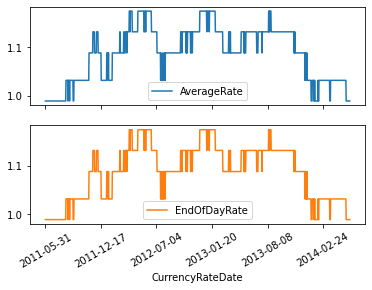

In [28]:
# Draw the progression of the two rates over time
currency_rate_smoothed_df.plot(subplots=True)
plt.xticks(rotation=30)

In addition to histogram analysis and binning, there are other methods of discretization. One of them - clustering - will be covered later in the semester.

### Data Reduction

Another important part of data preprocessing is to reduce the dimentionality of data. One focus in the lecture was Principal Component Analysis (PCA), which we now utilize.

Subject of analysis is still the `currency_rate_df` where `AverageRate` and `EndOfDayRate` are visibly the same. It is, therefore, expected that a large part of the redundancy can be eliminated by PCA.

In order to generate a deep understanding on PCA, you will first apply the steps presented in the lecture before resorting to a library function.

<div class="alert alert-block alert-info">

**Task:** Standardize the `currency_rate_df` to ensure that all attributes are included in the analysis to the same extent. (Hint: You may use one of your previous defined functions) 
</div>

In [29]:
# Standardize currency_rate_df

In [30]:
# Standardize currency_rate_df
standardized_currency_rate_df = z_score_normalization(currency_rate_df)

# Although not part of the question, it is usually helpful to display the result of the calculation
standardized_currency_rate_df.head(20)

,AverageRate,EndOfDayRate
CurrencyRateDate,,
2011-05-31,-2.052818,-2.042908
2011-06-01,-2.089427,-2.100453
2011-06-02,-2.204485,-2.196360
2011-06-03,-2.192282,-2.192872
2011-06-04,-2.040615,-2.028958
2011-06-05,-2.016209,-2.021983
2011-06-06,-2.033642,-2.020239
2011-06-07,-2.052818,-2.065577
2011-06-08,-2.052818,-2.037677


<div class="alert alert-block alert-info">

**Task:** Calculate the covariance matrix for the standardized `DataFrame`. (Help: [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cov.html))
</div>

In [31]:
# Calculate covariance matrix

In [32]:
# Calculate covariance matrix
covariance_matrix = standardized_currency_rate_df.cov()

# Display the covariance matrix
covariance_matrix

,AverageRate,EndOfDayRate
AverageRate,1.000000,0.999948
EndOfDayRate,0.999948,1.000000


<div class="alert alert-block alert-info">

**Task:** Calculate the associated eigenvalues and eigenvectors. (Help: [Numpy documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html)) 
</div>

In [33]:
# Calculate the associated eigenvalues and eigenvectors

In [44]:
# Calculate the associated eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Display the eigenvalues and eigenvectors
print("Eigenvalues:")
print(eigenvalues)

print("\nEigenvectors:")
print(eigenvectors)

Eigenvalues:
[1.99994846e+00 5.15360040e-05]

Eigenvectors:
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


<div class="alert alert-block alert-info">

**Task:** Calculate the percentage of information per eigenvector.
</div>

In [35]:
# Calculate the percentage of information per eigenvector

In [36]:
# Calculate the percentage of information per eigenvector
relative_information_share = eigenvalues / np.sum(eigenvalues)

# Print the information
print(
    "First eigenvektor: approx. {0:.0f}% (Exact: ".format(
        relative_information_share[0] * 100
    )
    + str(relative_information_share[0])
    + ")"
)
print(
    "Second eigenvektor: approx. {0:.0f}% (Exact: ".format(
        relative_information_share[1] * 100
    )
    + str(relative_information_share[1])
    + ")"
)

First eigenvektor: approx. 100% (Exact: 0.999974231997985)
Second eigenvektor: approx. 0% (Exact: 2.5768002014980855e-05)


<div class="alert alert-block alert-info">

**Task:** Select the feature matrix so that the transformation preserves at least 80% of the information contained in the standardized `currency_rate_df`. 
</div>

In [37]:
# Select the feature matrix

In [38]:
# Select the feature matrix
# The first eigenvector contains nearly all information => select only that one
feature_matrix = eigenvectors[1]

# Print the feature_matrix
feature_matrix

array([0.70710678, 0.70710678])

<div class="alert alert-block alert-info">

**Task:** Perform the transformation of the standardized data frame using the feature matrix and display the result. (Help: [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dot.html)) 
</div>

In [39]:
# Perform the transformation and display the result

In [40]:
# Perform the transformation
transformated_currency_rate_df = pd.DataFrame(
    data=standardized_currency_rate_df.dot(feature_matrix)
)

# Display the transformated DataFrame
transformated_currency_rate_df.head(20)

,0
CurrencyRateDate,
2011-05-31,-2.896116
2011-06-01,-2.962693
2011-06-02,-3.111867
2011-06-03,-3.100772
2011-06-04,-2.877623
2011-06-05,-2.855433
2011-06-06,-2.866527
2011-06-07,-2.912145
2011-06-08,-2.892417


In this exercise, PCA allowed the two original attributes to be merged into one without any significant loss of information. Of course, it is very cumbersome to execute PCA step by step manually each time which is why PCA is also included in some ML frameworks such as scikit learn. 

It is very important to know exactly what the framework does for you and what it does not. For example, scikit-learn's PCA does not include standardization, although feature scaling [is strongly recommended](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html) by the framework itself as a preceding step.

<div class="alert alert-block alert-info">

**Task:** Use scikit-learn's PCA to transform the standardized `currency_rate_df` a second time. This time you may assume that only one component is expected to be used as a result. Display the result. (Help: [Scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)) 

</div>

In [41]:
# Use PCA from scikit-learn

In [42]:
# Instantiate a PCA object
pca = sklearn.decomposition.PCA(n_components=1)

# Compute the principal components for the standardized_currency_rate_df
transformated_currency_rate_df = pd.DataFrame(
    data=pca.fit_transform(standardized_currency_rate_df),
    index=standardized_currency_rate_df.index,
)

# Display the transformed DataFrame
transformated_currency_rate_df.head(20)

,0
CurrencyRateDate,
2011-05-31,2.896116
2011-06-01,2.962693
2011-06-02,3.111867
2011-06-03,3.100772
2011-06-04,2.877623
2011-06-05,2.855433
2011-06-06,2.866527
2011-06-07,2.912145
2011-06-08,2.892417


<div class="alert alert-block alert-info">

**Task:** It may be that the results of the manual PCA and scikit-learn's PCA differ. Explain why both results may well be correct. 

</div>

Write down your solution here:

One of the steps in PCA is the determination of eigenvalues and eigenvectors. This step is done by solving a system of equations that may lead to several correct solutions. Of course, different solutions do not lead to an identical result of the PCA, but since they are all valid solutions for the corresponding system of equations, all results are also valid results of a PCA. 